<a href="https://colab.research.google.com/github/yanting04/getting-started/blob/master/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms




In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

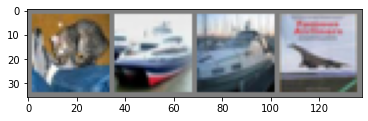

  cat ship shipplane


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
dataiter=iter(testloader)  
images,labels=dataiter.next()
images = images[:4,:,:]
imshow(torchvision.utils.make_grid(images))
print(''.join('%5s'% classes[labels[j]] for j in range(4) ))



In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Vgg16_net(nn.Module):
    def __init__(self):
        super(Vgg16_net, self).__init__()


        self.layer1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), #(32-3+2)/1+1=32   32*32*64
            nn.BatchNorm2d(64),
            
            nn.ReLU(inplace=True),
            

            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), #(32-3+2)/1+1=32    32*32*64
            
            # On the one hand, the data distribution is made consistent, and on the other hand, the gradient disappears.
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2,stride=2)   #(32-2)/2+1=16         16*16*64
        )


        self.layer2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),  #(16-3+2)/1+1=16  16*16*128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), #(16-3+2)/1+1=16   16*16*128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)    #(16-2)/2+1=8     8*8*128
        )

        self.layer3=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),  #(8-3+2)/1+1=8   8*8*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),


            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),  #(8-3+2)/1+1=8   8*8*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),  #(8-3+2)/1+1=8   8*8*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)     #(8-2)/2+1=4      4*4*256
        )

        self.layer4=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),  #(4-3+2)/1+1=4    4*4*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),   #(4-3+2)/1+1=4    4*4*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),   #(4-3+2)/1+1=4    4*4*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)    #(4-2)/2+1=2     2*2*512
        )

        self.layer5=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),   #(2-3+2)/1+1=2    2*2*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),  #(2-3+2)/1+1=2     2*2*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),  #(2-3+2)/1+1=2      2*2*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)   #(2-2)/2+1=1      1*1*512
        )


        self.conv=nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5
        )

        self.fc=nn.Sequential(
            
            nn.Linear(512,512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512,256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256,10)
        )


    def forward(self,x):
        x=self.conv(x)
        
        x = x.view(-1, 512)
        x=self.fc(x)
        return x


model=Vgg16_net().to(device)



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [ ]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
        running_loss = 0.0

print('Finished Training')
torch.save(model,'/content/gdrive/MyDrive/teacher.pth')

[1,     1] loss: 2.326
[1,     2] loss: 2.321
[1,     3] loss: 2.332
[1,     4] loss: 2.321
[1,     5] loss: 2.317
[1,     6] loss: 2.332
[1,     7] loss: 2.324
[1,     8] loss: 2.309
[1,     9] loss: 2.319
[1,    10] loss: 2.299
[1,    11] loss: 2.308
[1,    12] loss: 2.308
[1,    13] loss: 2.307
[1,    14] loss: 2.305
[1,    15] loss: 2.293
[1,    16] loss: 2.307
[1,    17] loss: 2.288
[1,    18] loss: 2.284
[1,    19] loss: 2.287
[1,    20] loss: 2.286
[1,    21] loss: 2.276
[1,    22] loss: 2.280
[1,    23] loss: 2.277
[1,    24] loss: 2.278
[1,    25] loss: 2.258
[1,    26] loss: 2.277
[1,    27] loss: 2.268
[1,    28] loss: 2.265
[1,    29] loss: 2.262
[1,    30] loss: 2.250
[1,    31] loss: 2.244
[1,    32] loss: 2.244
[1,    33] loss: 2.241
[1,    34] loss: 2.248
[1,    35] loss: 2.239
[1,    36] loss: 2.234
[1,    37] loss: 2.223
[1,    38] loss: 2.226
[1,    39] loss: 2.233
[1,    40] loss: 2.242
[1,    41] loss: 2.202
[1,    42] loss: 2.211
[1,    43] loss: 2.211
[1,    44] 

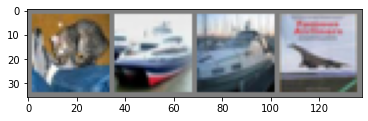

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4,:,:]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))



In [10]:
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))



Predicted:    cat  ship truck plane


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu()==labels.cpu()).squeeze().sum().numpy()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the 10000 test images: 67 %


In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu()==labels.cpu()).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



Accuracy of plane : 71 %
Accuracy of   car : 79 %
Accuracy of  bird : 52 %
Accuracy of   cat : 46 %
Accuracy of  deer : 59 %
Accuracy of   dog : 58 %
Accuracy of  frog : 71 %
Accuracy of horse : 71 %
Accuracy of  ship : 78 %
Accuracy of truck : 78 %
